In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import FinanceDataReader as fdr
import seaborn as sns
from matplotlib import dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
from pykrx import stock
from xml.etree import ElementTree
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
stocks = ['삼성전자','SK하이닉스','현대자동차','NAVER']

In [3]:
def myplot(df, nrows=5,  kind='line', title='제목', labels=False):  
    if nrows > 0:
        print(df.head(nrows))
    else:
        print(df.tail(nrows))
    
    if labels:
        cols = df.columns
        for i, col in enumerate(cols):
            df[col].plot(label=labels[i], kind=kind)
    else :
        df.plot(kind=kind)
    
    plt.title(title)
    plt.legend()
    plt.show()

In [4]:
def myplotmix(df1, df2, y1='ylabel-1', y2='ylabel-2', kind1='bar', kind2='line', title='제목',  nrows1=5, nrows2=5,  labels=False):  
    ytl=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    if nrows1 > 0:
        print(df1.head(nrows1))
    elif nrows1 < 0:
        print(df1.tail(nrows1))
    if nrows2 > 0:
        print(df2.head(nrows2))
    else:
        print(df2.tail(nrows2))
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax2=ax1.twinx()
    if kind1 == 'line':
        df1.plot(kind=kind1, ax=ax2, marker='d',color='#e35f62')  #color='y', 
        df2.plot(kind=kind2, ax=ax1)  #bar
    else:
        df1.plot(kind=kind1, ax=ax1,color='#bcbd22')
        df2.plot(kind=kind2, ax=ax2) #color='y',
        
    # df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    # ax1.set_xticklabels(df['date'])    
    ax1.yaxis.tick_right()
    ax2.yaxis.tick_left()
    ax1.set_ylabel(y1) #, color='red')
    ax2.set_ylabel(y2) #, color='red')
    ax1.legend(loc=1)
    ax2.legend(loc=2)
    plt.title(title)
    ax1.grid(False)
    ax2.grid(False)
    plt.show()

In [5]:
def my_ticker(names):    
    df_code = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]
    df_code.종목코드 = df_code.종목코드.map('{:06d}'.format)

    df_code = df_code[['회사명', '종목코드']]
    code_list = []
    for name in names:
        code = df_code.query("회사명=='{}'".format(name))['종목코드'].to_string(index=False)
        code_list.append(code)
    return code_list

# stocks = my_ticker(['삼성전자', 'SK하이닉스', '현대자동차', 'NAVER'])
# print(stocks)

In [6]:
def my_krx(start, end, *codes):
    error_list = []
    failed = 0
    success = 0
    df = pd.DataFrame()
    for code in codes:
        try: 
            df = stock.get_market_ohlcv_by_date(start, end, code)
            df.reset_index(inplace=True)
            df.insert(loc=1, column='종목코드', value=code)
            df.columns = ['date', 'code', 'open', 'high', 'low', 'close','volume']
            success += 1
        except ElementTree.ParseError as e:
            error_list.append(e)
            drop_rows(database, table, code)  # 특정 종목코드에서 에러 발생 시 해당 종목코드에 대한 데이터 삭제 후 다음 종목코드로 넘어감
            failed += 1
            continue
        except Exception as e:
            print('Error occurred : ', e)
            failed += 1
            continue
    print(f'success:{success}, failed:{failed}')
    return df
my_krx('20180101', '20191231', '005930')

success:1, failed:0


,date,code,open,high,low,close,volume
0,2018-01-02,005930,51380,51400,50780,51020,169485
1,2018-01-03,005930,52540,52560,51420,51620,200270
2,2018-01-04,005930,52120,52180,50640,51080,233909
3,2018-01-05,005930,51300,52120,51200,52120,189623
4,2018-01-08,005930,52400,52520,51500,52020,167673
...,...,...,...,...,...,...,...
485,2019-12-23,005930,56100,56400,55100,55500,9839252
486,2019-12-24,005930,55600,55700,54800,55000,11868463
487,2019-12-26,005930,54700,55400,54400,55400,9645034
488,2019-12-27,005930,55700,56900,55500,56500,12313056


In [7]:
stocks = ['삼성전자', 'SK하이닉스', '현대자동차', 'NAVER']
stocks_code = my_ticker(stocks)
print(stocks_code)  #['005930', '000660', '005380', '035420']

df = pd.DataFrame()
for i, sname in enumerate(stocks):
#     print(sname, stocks_code[i])    
    df[sname] = my_krx('20180101', '20191231', stocks_code[i])['close']
df.head()

['005930', '000660', '005380', '035420']
success:1, failed:0
success:1, failed:0
success:1, failed:0
success:1, failed:0


,삼성전자,SK하이닉스,현대자동차,NAVER
0,51020,76600,149500,177251
1,51620,77700,150500,174447
2,51080,77100,146500,178853
3,52120,79300,149000,181857
4,52020,78200,151000,190269


# 수익률

In [8]:
temp = df[['삼성전자','SK하이닉스']].copy()
temp['어제shift(1)'] = df['SK하이닉스'].shift(1)
temp['변동가'] =   df['SK하이닉스'] - temp['어제shift(1)'] 
temp['어제pct_ch()'] = df['SK하이닉스'].pct_change(1) #변동률
temp['이동평균가(rolling)'] = df['SK하이닉스'].rolling(2).mean()
temp.head()


,삼성전자,SK하이닉스,어제shift(1),변동가,어제pct_ch(),이동평균가(rolling)
0,51020,76600,NaN,NaN,NaN,NaN
1,51620,77700,76600.0,1100.0,0.014360,77150.0
2,51080,77100,77700.0,-600.0,-0.007722,77400.0
3,52120,79300,77100.0,2200.0,0.028534,78200.0
4,52020,78200,79300.0,-1100.0,-0.013871,78750.0


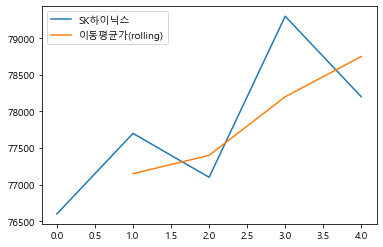

In [9]:
plt.plot(temp['SK하이닉스'].iloc[:5], label='SK하이닉스')
plt.plot(temp['이동평균가(rolling)'].iloc[:5], label='이동평균가(rolling)')
plt.legend()

In [10]:
df / df.shift(1)

,삼성전자,SK하이닉스,현대자동차,NAVER
0,NaN,NaN,NaN,NaN
1,1.011760,1.014360,1.006689,0.984181
2,0.989539,0.992278,0.973422,1.025257
3,1.020360,1.028534,1.017065,1.016796
4,0.998081,0.986129,1.013423,1.046256
...,...,...,...,...
485,0.991071,0.995789,0.987903,1.002725
486,0.990991,0.991543,0.995918,0.989130
487,1.007273,1.010661,1.004098,0.991758
488,1.019856,1.012658,0.983673,1.016620


In [11]:
dflog = np.log(df / df.shift(1))
dflog.dropna(axis=0, inplace=True)
dflog.head()

,삼성전자,SK하이닉스,현대자동차,NAVER
1,0.011691,0.014258,0.006667,-0.015946
2,-0.010516,-0.007752,-0.026938,0.024943
3,0.020156,0.028135,0.016921,0.016656
4,-0.001920,-0.013968,0.013334,0.045218
5,-0.031637,-0.016764,0.009885,-0.006332


# 기대수익률

In [12]:
ym = dflog[['삼성전자','SK하이닉스']].mean()
ym.values

array([0.00018314, 0.00042078])

In [13]:
w = np.array([0.7, 0.3]).reshape(-1,1)
ym = ym.values
print(w, ym)

[[0.7]
 [0.3]] [0.00018314 0.00042078]


In [14]:
res = ym.dot(w)
res

array([0.00025443])

# 효율적 배분

In [15]:
ws = np.arange(.1, 1.0, .1)

for i in ws:
    w = np.array([i, 1-i])
    res = ym.dot(w)
    print(w, res)

[0.1 0.9] 0.0003970153139625126
[0.2 0.8] 0.0003732515484878322
[0.3 0.7] 0.0003494877830131518
[0.4 0.6] 0.00032572401753847144
[0.5 0.5] 0.00030196025206379105
[0.6 0.4] 0.00027819648658911067
[0.7 0.3] 0.0002544327211144303
[0.8 0.2] 0.0002306689556397499
[0.9 0.1] 0.00020690519016506952


# 리스크

In [16]:
day_std = dflog[['삼성전자','SK하이닉스']].std()
year_std = day_std * np.sqrt(252)
print(year_std)

삼성전자      0.250593
SK하이닉스    0.355185
dtype: float64


In [17]:
day_cov = dflog[['삼성전자','SK하이닉스']].cov()
ym_cov = day_cov * 252
print(ym_cov)

            삼성전자    SK하이닉스
삼성전자    0.062797  0.059889
SK하이닉스  0.059889  0.126156


# 효율적 투자선

In [18]:
dflog = dflog[['삼성전자','SK하이닉스']]
dflog.head()

,삼성전자,SK하이닉스
1,0.011691,0.014258
2,-0.010516,-0.007752
3,0.020156,0.028135
4,-0.001920,-0.013968
5,-0.031637,-0.016764


# 몬테카를로

In [19]:
 
daily_ret = df.pct_change() 
annual_ret = daily_ret.mean() * 252
daily_cov = daily_ret.cov() 
annual_cov = daily_cov * 252

port_ret = [] 
port_risk = [] 
port_weights = [] 

for _ in range(20000): 
    weights = np.random.random(len(stocks)) 
    weights /= np.sum(weights) 

    returns = np.dot(weights, annual_ret) 
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) 

    port_ret.append(returns) 
    port_risk.append(risk) 
    port_weights.append(weights) 

portfolio = {'Returns': port_ret, 'Risk': port_risk} 
# for i, s in enumerate(stocks): 
#     portfolio[s] = [weight[i] for weight in port_weights] 
# df = pd.DataFrame(portfolio) 
# df = df[['Returns', 'Risk'] + [s for s in stocks]] 

port_df = pd.DataFrame({"수익률": port_ret, 
                        "리스크": port_risk,
                       "삼성전자 가중치":np.array(port_weights)[:,0],
                        "SK하이닉스 가중치":np.array(port_weights)[:,1]})



In [20]:
port_df.head()

,수익률,리스크,삼성전자 가중치,SK하이닉스 가중치
0,0.099708,0.224849,0.257307,0.401742
1,0.032990,0.189200,0.480898,0.084162
2,0.065509,0.257761,0.116306,0.032362
3,0.049311,0.193852,0.203299,0.142449
4,0.064956,0.205601,0.430715,0.037678


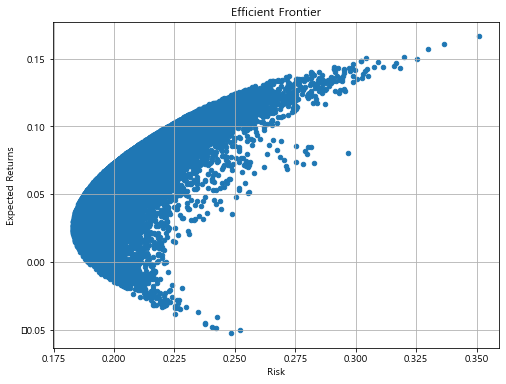

In [21]:
port_df.plot.scatter(x='리스크', y='수익률', figsize=(8, 6), grid=True)
plt.title('Efficient Frontier') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
plt.show() 

# 샤프

In [22]:
# 샤프지수 = port_df['수익률'] / port_df['수익률'].std()

#샤프 비율 : 위험 대비 자산 수익률
샤프지수 = port_df['수익률'] / port_df['리스크']
port_df['샤프지수'] = 샤프지수
port_df.head()

,수익률,리스크,삼성전자 가중치,SK하이닉스 가중치,샤프지수
0,0.099708,0.224849,0.257307,0.401742,0.443443
1,0.032990,0.189200,0.480898,0.084162,0.174364
2,0.065509,0.257761,0.116306,0.032362,0.254146
3,0.049311,0.193852,0.203299,0.142449,0.254375
4,0.064956,0.205601,0.430715,0.037678,0.315933


In [23]:
idx = 샤프지수[샤프지수== max(샤프지수)]
maxsharp = port_df.iloc[idx]
maxsharp

,수익률,리스크,삼성전자 가중치,SK하이닉스 가중치,샤프지수
0,0.099708,0.224849,0.257307,0.401742,0.443443


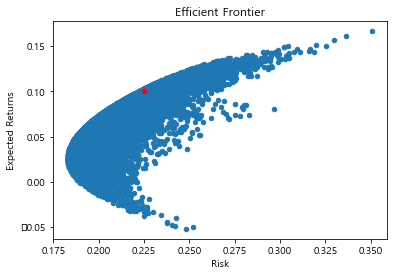

In [24]:
port_df.plot.scatter(x='리스크', y='수익률')
plt.scatter(x=maxsharp['리스크'], y=maxsharp['수익률'] , marker='*' , color='red')
plt.title('Efficient Frontier') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
plt.show() 

In [ ]:
port_df = pd.DataFrame({"수익률": return_list, "삼성전자 리스크": np.array(risk_list)[:,0],"SK하이닉스 리스크":np.array(risk_list)[:,1],
                       "삼성전자 가중치":np.array(w_list)[:,0],"SK하이닉스 가중치":np.array(w_list)[:,1]})
